In [8]:
# Grouped and deduplicated for clarity. Feel free to tweak.
import os, multiprocessing as mp
cores = mp.cpu_count()
os.environ["TF_NUM_INTRAOP_THREADS"] = str(cores)  # parallel within ops
os.environ["TF_NUM_INTEROP_THREADS"] = "2"         # parallel across ops
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"          # Intel-optimized kernels

import tensorflow as tf
tf.config.optimizer.set_jit(True)  # try XLA on CPU
gpus = tf.config.experimental.list_physical_devices("GPU")
print("TF:", tf.__version__)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected")

# --- Standard Library ---
import os; import sys; import logging; import time; import numpy as np; import tensorflow as tf
from datetime import datetime
import time; import numpy as np
import os; import tensorflow as tf
import os; import io; import contextlib; import tensorflow as tf
import os
import os; import numpy as np; import matplotlib.pyplot as plt
import os; import numpy as np
import math
# --- Scientific Stack ---
import numpy as np
# --- Plotting ---
import matplotlib.pyplot as plt
# --- Scikit-learn & Metrics ---
from sklearn.model_selection import train_test_split
# --- Other Third-Party ---
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from src.models.utils import show_random_datapoint
from models.lossfunc import jaccard_coef, dice_coef, dice_loss, jaccard_coef_loss, FocalLoss, bce_loss, bce_dice, bce_jaccard, bce_focal, bce_dice_focal
from models.unet import simple_unet_model
from models.utils import read_images_and_masks, show_random_datapoint
import tensorflow as tf; import gc
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

TF: 2.15.0
No GPU detected


In [9]:
image_directory = r"/home/anvy4548/projects/Crystal_recognition/dataprep/everything/patches_for_training/aug/images/"  # Change this to your output images directory
mask_directory = r"/home/anvy4548/projects/Crystal_recognition/dataprep/everything/patches_for_training/aug/masks/"  # Change this to your output masks directory

SIZE = 256

image_dataset, mask_dataset = read_images_and_masks(image_directory, mask_directory, SIZE)

print("Image dataset size: " + str(image_dataset.shape))
print("Mask dataset size: " + str(mask_dataset.shape))

5016
Image dataset size: (5016, 256, 256, 1)
Mask dataset size: (5016, 256, 256, 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train = X_train.astype('float32'); X_test = X_test.astype('float32')
y_train = y_train.astype('float32'); y_test = y_test.astype('float32')

No GPU detected


3966


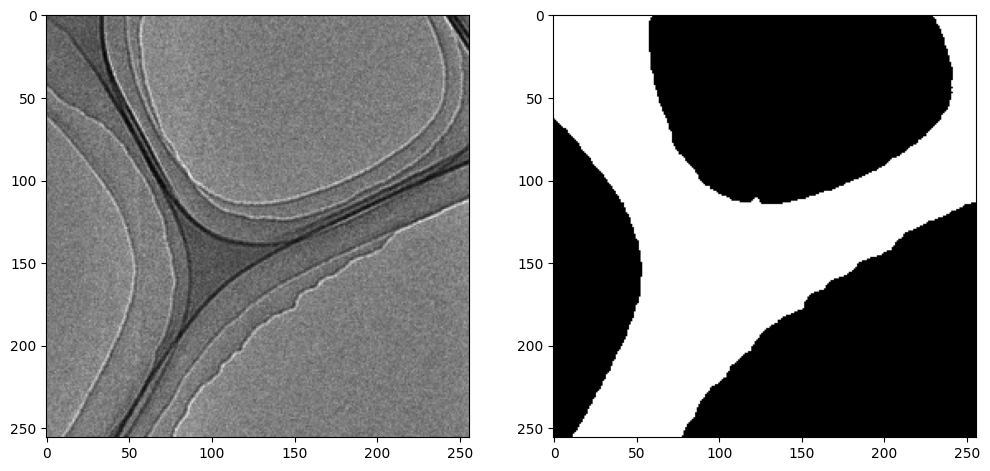

In [15]:
show_random_datapoint(image_dataset, mask_dataset)

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]
# metrics to track
metrics = [dice_coef, jaccard_coef]

model_bce         = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss='binary_crossentropy', metrics=metrics)

model_bce_fn      = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=bce_loss, metrics=metrics)  # same as above but via callable

model_dice        = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=dice_loss, metrics=metrics)

model_jaccard     = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=jaccard_coef_loss, metrics=metrics)

model_focal       = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=FocalLoss, metrics=metrics)

# hybrids (from earlier)
model_bce_dice    = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=bce_dice, metrics=metrics)

model_bce_jaccard = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=bce_jaccard, metrics=metrics)

model_bce_focal   = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=bce_focal, metrics=metrics)

model_bce_dice_focal = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                         loss=bce_dice_focal, metrics=metrics)

In [ ]:
# setup
logdir = "logs"; os.makedirs(logdir, exist_ok=True)
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
log_path = os.path.join(logdir, f"train_{run_id}.log")

logger = logging.getLogger("train")
logger.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")  # local time (Stockholm)
fh = logging.FileHandler(log_path); fh.setFormatter(fmt)
sh = logging.StreamHandler(sys.stdout); sh.setFormatter(fmt)
logger.handlers.clear(); logger.addHandler(fh); logger.addHandler(sh)

def fmt_logs(logs):
    logs = logs or {}
    parts = [f"{k}={v:.4f}" if isinstance(v, (float, np.floating)) else f"{k}={v}"
             for k, v in sorted(logs.items())]
    return " ".join(parts)

class LogCallback(Callback):
    def on_train_begin(self, logs=None):
        logger.info("Training start | params=%s", self.params)
    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.perf_counter() - self._t0
        logger.info("epoch=%d | %s | epoch_sec=%.2f", epoch, fmt_logs(logs), dt)
    def on_train_end(self, logs=None):
        logger.info("Training end")

In [ ]:
class CSVLoggerWithTime(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = dict(logs or {})
        logs["timestamp"] = datetime.now().isoformat(timespec="seconds")
        super().on_epoch_end(epoch, logs)

csv_cb = CSVLoggerWithTime(os.path.join(logdir, f"history_{run_id}.csv"))

In [ ]:
print("X_train", X_train.shape, X_train.dtype, X_train.min(), X_train.max())
print("y_train", y_train.shape, y_train.dtype, y_train.min(), y_train.max())
print("pos frac train:", float(y_train.mean()), " | pos frac val:", float(y_test.mean()))

In [ ]:
class EpochTimer(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.perf_counter() - self._t0)

class SegDebug(Callback):
    def __init__(self, x_val, y_val, n=128, thr=0.5):
        super().__init__()
        self.x = x_val[:n]; self.y = y_val[:n]; self.thr = thr

    def on_train_begin(self, logs=None):
        print(f"[dbg] y_val pos frac: {float(self.y.mean()):.3f}")

    def on_epoch_end(self, epoch, logs=None):
        p = self.model.predict(self.x, verbose=0)
        pm = float(p.mean()); pf = float((p > self.thr).mean())
        inter = float(np.logical_and(p > self.thr, self.y > 0.5).mean())
        print(f"[dbg] epoch {epoch:03d} pred_mean={pm:.3f}  pred>thr={pf:.3f}  IoU(quick)≈{inter:.3f}")


metrics = [dice_coef, jaccard_coef, BinaryAccuracy(name='accuracy', threshold=0.5), Precision(name='prec'), Recall(name='rec')]
losses = {

    "dice": dice_loss,
    "jaccard": jaccard_coef_loss,
    "focal": FocalLoss,
    "bce": "binary_crossentropy",
    "bce_dice": bce_dice,
    "bce_jaccard": bce_jaccard,
    "bce_focal": bce_focal,
    "bce_dice_focal": bce_dice_focal
}
models = {n: simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, loss=f, metrics=metrics)
          for n, f in losses.items()}

histories, runtimes = {}, {}

for name, model in models.items():
    tf.keras.backend.clear_session()
    print(f"\n=== {name} ===")
    timer = EpochTimer()
    cbs = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss"),
        ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor="val_loss"),
        ModelCheckpoint(f"unet_{name}", monitor="val_loss", save_best_only=True,
    save_weights_only=True),
        timer,
        SegDebug(X_test, y_test, n=128, thr=0.5),
        LogCallback(),          # text log with epoch timing + metrics
        csv_cb,                 # CSV with metrics + timestamp
    ]
    t0 = time.perf_counter()
    hist = model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=10,
        validation_data=(X_test, y_test),
        shuffle=True,
        verbose=1,
        callbacks=cbs,
    )
    total = time.perf_counter() - t0
    histories[name] = dict(hist.history)    # store dict, not History object

    runtimes[name] = {
        "total_sec": total,
        "epochs_ran": len(timer.epoch_times),
        "mean_epoch_sec": float(np.mean(timer.epoch_times)),
        "last_epoch_sec": float(timer.epoch_times[-1]),
    }
    del model; tf.keras.backend.clear_session(); gc.collect()
# quick summary
for k, v in runtimes.items():
    print(f"{k:16s}  total: {v['total_sec']:.1f}s | epochs: {v['epochs_ran']} | mean/epoch: {v['mean_epoch_sec']:.2f}s")

In [ ]:
# If you change the checkpoint name, keep this in sync with your ModelCheckpoint filepath
def ckpt_path(name):
    # prefer single-file weights
    h5 = f"unet_{name}"
    if os.path.exists(h5):
        return h5
    # fallback: TF checkpoint prefix/folder (when no extension was used)
    tfckpt = f"unet_{name}"
    return tfckpt

evals = {}

for name, loss_fn in losses.items():
    tf.keras.backend.clear_session()
    # rebuild with SAME loss & metrics used during training
    m = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, loss=loss_fn, metrics=metrics)

    # load best weights
    m.load_weights(ckpt_path(name))

    # evaluate
    r = m.evaluate(X_test, y_test, verbose=0, return_dict=True)
    evals[name] = r
    print(f"{name:16s}  loss={r['loss']:.4f}  dice={r.get('dice_coef', float('nan')):.4f}  "
          f"iou={r.get('jaccard_coef', float('nan')):.4f}  acc={r.get('accuracy', float('nan')):.4f}  "
          f"prec={r.get('prec', float('nan')):.4f}  rec={r.get('rec', float('nan')):.4f}")

In [ ]:
for name, m in models.items():
    r = m.evaluate(X_test, y_test, verbose=0, return_dict=True)
    print(f"{name:16s} loss={r['loss']:.4f}  dice={r.get('dice_coef', float('nan')):.4f}  iou={r.get('jaccard_coef', float('nan')):.4f}  acc={r.get('accuracy', float('nan')):.4f}")

In [ ]:
    Dropout, Lambda


    bce_jaccard, bce_focal, bce_dice_focal

image_directory = r"/home/anvy4548/projects/Crystal_recognition/dataprep/everything/patches_for_training/aug/images"  # Change this to your output images directory
mask_directory = r"/home/anvy4548/projects/Crystal_recognition/dataprep/everything/patches_for_training/aug/masks"  # Change this to your output masks directory

SIZE = 256

image_dataset, mask_dataset = read_images_and_masks(image_directory, mask_directory, SIZE)

print("Image dataset size: " + str(image_dataset.shape))
print("Mask dataset size: " + str(mask_dataset.shape))

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=0)
X_train = X_train.astype('float32');
X_test = X_test.astype('float32')
y_train = y_train.astype('float32');
y_test = y_test.astype('float32')

gpus = tf.config.experimental.list_physical_devices("GPU")
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)
show_random_datapoint(image_dataset, mask_dataset)
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]
# metrics to track
metrics = [dice_coef, jaccard_coef]

model_bce = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                              loss='binary_crossentropy', metrics=metrics)

model_bce_fn = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                 loss=bce_loss, metrics=metrics)  # same as above but via callable

model_dice = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                               loss=dice_loss, metrics=metrics)

model_jaccard = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                  loss=jaccard_coef_loss, metrics=metrics)

model_focal = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                loss=FocalLoss, metrics=metrics)

# hybrids (from earlier)
model_bce_dice = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                   loss=bce_dice, metrics=metrics)

model_bce_jaccard = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                      loss=bce_jaccard, metrics=metrics)

model_bce_focal = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                    loss=bce_focal, metrics=metrics)

model_bce_dice_focal = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                         loss=bce_dice_focal, metrics=metrics)


# setup
logdir = "logs";
os.makedirs(logdir, exist_ok=True)
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
log_path = os.path.join(logdir, f"train_{run_id}.log")

logger = logging.getLogger("train")
logger.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")  # local time (Stockholm)
fh = logging.FileHandler(log_path);
fh.setFormatter(fmt)
sh = logging.StreamHandler(sys.stdout);
sh.setFormatter(fmt)
logger.handlers.clear();
logger.addHandler(fh);
logger.addHandler(sh)


def fmt_logs(logs):
    logs = logs or {}
    parts = [f"{k}={v:.4f}" if isinstance(v, (float, np.floating)) else f"{k}={v}"
             for k, v in sorted(logs.items())]
    return " ".join(parts)


class LogCallback(Callback):
    def on_train_begin(self, logs=None):
        logger.info("Training start | params=%s", self.params)

    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        dt = time.perf_counter() - self._t0
        logger.info("epoch=%d | %s | epoch_sec=%.2f", epoch, fmt_logs(logs), dt)

    def on_train_end(self, logs=None):
        logger.info("Training end")




class CSVLoggerWithTime(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = dict(logs or {})
        logs["timestamp"] = datetime.now().isoformat(timespec="seconds")
        super().on_epoch_end(epoch, logs)


csv_cb = CSVLoggerWithTime(os.path.join(logdir, f"history_{run_id}.csv"))

print("X_train", X_train.shape, X_train.dtype, X_train.min(), X_train.max())
print("y_train", y_train.shape, y_train.dtype, y_train.min(), y_train.max())
print("pos frac train:", float(y_train.mean()), " | pos frac val:", float(y_test.mean()))



class EpochTimer(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.perf_counter() - self._t0)


class SegDebug(Callback):
    def __init__(self, x_val, y_val, n=128, thr=0.5):
        super().__init__()
        self.x = x_val[:n];
        self.y = y_val[:n];
        self.thr = thr

    def on_train_begin(self, logs=None):
        print(f"[dbg] y_val pos frac: {float(self.y.mean()):.3f}")

    def on_epoch_end(self, epoch, logs=None):
        p = self.model.predict(self.x, verbose=0)
        pm = float(p.mean());
        pf = float((p > self.thr).mean())
        inter = float(np.logical_and(p > self.thr, self.y > 0.5).mean())
        print(f"[dbg] epoch {epoch:03d} pred_mean={pm:.3f}  pred>thr={pf:.3f}  IoU(quick)≈{inter:.3f}")


metrics = [dice_coef, jaccard_coef, BinaryAccuracy(name='accuracy', threshold=0.5), Precision(name='prec'),
           Recall(name='rec')]
losses = {

    "dice": dice_loss,
    "jaccard": jaccard_coef_loss,
    "focal": FocalLoss,
    "bce": "binary_crossentropy",
    "bce_dice": bce_dice,
    "bce_jaccard": bce_jaccard,
    "bce_focal": bce_focal,
    "bce_dice_focal": bce_dice_focal
}
models = {n: simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, loss=f, metrics=metrics)
          for n, f in losses.items()}

histories, runtimes = {}, {}

for name, model in models.items():
    tf.keras.backend.clear_session()
    print(f"\n=== {name} ===")
    timer = EpochTimer()
    cbs = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss"),
        ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor="val_loss"),
        ModelCheckpoint(f"unet_{name}", monitor="val_loss", save_best_only=True,
                        save_weights_only=True),
        timer,
        SegDebug(X_test, y_test, n=128, thr=0.5),
        LogCallback(),  # text log with epoch timing + metrics
        csv_cb,  # CSV with metrics + timestamp
    ]
    t0 = time.perf_counter()
    hist = model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=10,
        validation_data=(X_test, y_test),
        shuffle=True,
        verbose=1,
        callbacks=cbs,
    )
    total = time.perf_counter() - t0
    histories[name] = dict(hist.history)  # store dict, not History object

    runtimes[name] = {
        "total_sec": total,
        "epochs_ran": len(timer.epoch_times),
        "mean_epoch_sec": float(np.mean(timer.epoch_times)),
        "last_epoch_sec": float(timer.epoch_times[-1]),
    }
    del model;
    tf.keras.backend.clear_session();
    gc.collect()
# quick summary
for k, v in runtimes.items():
    print(f"{k:16s}  total: {v['total_sec']:.1f}s | epochs: {v['epochs_ran']} | mean/epoch: {v['mean_epoch_sec']:.2f}s")



# If you change the checkpoint name, keep this in sync with your ModelCheckpoint filepath
def ckpt_path(name):
    # prefer single-file weights
    h5 = f"unet_{name}"
    if os.path.exists(h5):
        return h5
    # fallback: TF checkpoint prefix/folder (when no extension was used)
    tfckpt = f"unet_{name}"
    return tfckpt


evals = {}

for name, loss_fn in losses.items():
    tf.keras.backend.clear_session()
    # rebuild with SAME loss & metrics used during training
    m = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, loss=loss_fn, metrics=metrics)

    # load best weights
    m.load_weights(ckpt_path(name))

    # evaluate
    r = m.evaluate(X_test, y_test, verbose=0, return_dict=True)
    evals[name] = r
    print(f"{name:16s}  loss={r['loss']:.4f}  dice={r.get('dice_coef', float('nan')):.4f}  "
          f"iou={r.get('jaccard_coef', float('nan')):.4f}  acc={r.get('accuracy', float('nan')):.4f}  "
          f"prec={r.get('prec', float('nan')):.4f}  rec={r.get('rec', float('nan')):.4f}")



# prefer single-file weights; fall back to TF checkpoint prefix/folder
def ckpt_path(name):
    h5 = f"unet_{name}.weights.h5"
    if os.path.exists(h5):
        return h5
    return f"unet_{name}"


evals = {}
_sink = io.StringIO()  # where we dump the silenced output

for name, loss_fn in losses.items():
    tf.keras.backend.clear_session()

    # build + load quietly so model.summary() (layers) doesn't print
    with contextlib.redirect_stdout(_sink), contextlib.redirect_stderr(_sink):
        m = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, loss=loss_fn, metrics=metrics)
        m.load_weights(ckpt_path(name))

    # evaluate (already quiet with verbose=0)
    r = m.evaluate(X_test, y_test, verbose=0, return_dict=True)
    evals[name] = r
    print(f"{name:16s}  loss={r['loss']:.4f}  dice={r.get('dice_coef', float('nan')):.4f}  "
          f"iou={r.get('jaccard_coef', float('nan')):.4f}  acc={r.get('accuracy', float('nan')):.4f}  "
          f"prec={r.get('prec', float('nan')):.4f}  rec={r.get('rec', float('nan')):.4f}")

for name, m in models.items():
    r = m.evaluate(X_test, y_test, verbose=0, return_dict=True)
    print(
        f"{name:16s} loss={r['loss']:.4f}  dice={r.get('dice_coef', float('nan')):.4f}  iou={r.get('jaccard_coef', float('nan')):.4f}  acc={r.get('accuracy', float('nan')):.4f}")

In [ ]:
# histories: dict like {"bce": dict(history), "dice": dict(history), ...}
os.makedirs("training_curves", exist_ok=True)

def to_hist_dict(h):
    """Accept either a keras History or a plain dict."""
    if isinstance(h, dict):
        return h
    if hasattr(h, "history"):
        return h.history
    raise TypeError("Unsupported history type")

def pick_metric_key(hd):
    # prefer these if both train & val series exist
    for m in ["dice_coef", "jaccard_coef", "accuracy", "prec", "rec"]:
        if m in hd and f"val_{m}" in hd:
            return m
    # fallback: any metric that has a val_ pair and isn't loss
    for k in hd.keys():
        if not k.startswith("val_") and k != "loss" and f"val_{k}" in hd:
            return k
    return None

def _trim(seq, n):
    return seq[:n] if hasattr(seq, "__len__") else seq

# per-model plots
for name, h in histories.items():
    hd = to_hist_dict(h)
    if "loss" not in hd or "val_loss" not in hd:
        print(f"{name}: missing loss/val_loss; skipping")
        continue

    n_loss = min(len(hd["loss"]), len(hd["val_loss"]))
    epochs = range(1, n_loss + 1)
    metric = pick_metric_key(hd)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss
    axes[0].plot(epochs, _trim(hd["loss"], n_loss), label="Train")
    axes[0].plot(epochs, _trim(hd["val_loss"], n_loss), label="Val")
    axes[0].set_title(f"{name}: Loss")
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss"); axes[0].legend()

    # Metric (if present)
    if metric:
        n_m = min(len(hd[metric]), len(hd[f"val_{metric}"]))
        epochs_m = range(1, n_m + 1)
        axes[1].plot(epochs_m, _trim(hd[metric], n_m), label=f"Train {metric}")
        axes[1].plot(epochs_m, _trim(hd[f"val_{metric}"], n_m), label=f"Val {metric}")
        axes[1].set_title(f"{name}: {metric}")
        axes[1].set_xlabel("Epoch"); axes[1].set_ylabel(metric); axes[1].legend()
    else:
        axes[1].axis("off")
        fig.suptitle(f"{name} (no metric found besides loss)", y=1.02)

    fig.tight_layout()
    fig.savefig(f"training_curves/{name}.png", dpi=160)
    plt.close(fig)

# comparison plot across models for a common metric (tries dice → jaccard → accuracy → prec → rec)
def has_metric(h, m):
    hd = to_hist_dict(h)
    return (m in hd) and (f"val_{m}" in hd)

common_metric = None
for m in ["dice_coef", "jaccard_coef", "accuracy", "prec", "rec"]:
    if all(has_metric(h, m) for h in histories.values()):
        common_metric = m
        break

if common_metric:
    plt.figure(figsize=(7, 5))
    for name, h in histories.items():
        hd = to_hist_dict(h)
        y = hd[f"val_{common_metric}"]
        plt.plot(range(1, len(y) + 1), y, label=name)
    plt.title(f"Validation {common_metric} across models")
    plt.xlabel("Epoch"); plt.ylabel(common_metric); plt.legend()
    plt.tight_layout()
    plt.savefig(f"training_curves/compare_val_{common_metric}.png", dpi=160)
    plt.close()
else:
    print("No single common metric across all models to compare (checked dice/jaccard/accuracy/prec/rec).")

In [ ]:
os.makedirs("training_curves", exist_ok=True)

def to_hist_dict(h):
    return h if isinstance(h, dict) else getattr(h, "history", {})

def have_hist_acc(histories):
    return all(("accuracy" in to_hist_dict(h) and "val_accuracy" in to_hist_dict(h))
               for h in histories.values())

# 1) Line plot: val_accuracy across epochs
if have_hist_acc(histories):
    plt.figure(figsize=(8,6))
    for name, h in histories.items():
        hd = to_hist_dict(h)
        y = hd["val_accuracy"]
        plt.plot(range(1, len(y)+1), y, label=name)
    plt.title("Validation accuracy across models")
    plt.xlabel("Epoch"); plt.ylabel("val_accuracy"); plt.legend()
    plt.tight_layout()
    plt.savefig("training_curves/compare_val_accuracy.png", dpi=160)
    plt.close()

    # 2) Bar chart: best val_accuracy per model
    best = {name: float(np.max(to_hist_dict(h)["val_accuracy"])) for name, h in histories.items()}
    names, vals = zip(*sorted(best.items(), key=lambda kv: kv[1], reverse=True))
    plt.figure(figsize=(8,5))
    plt.bar(names, vals)
    plt.ylabel("Best val_accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("training_curves/best_val_accuracy.png", dpi=160)
    plt.close()
else:
    print("accuracy/val_accuracy not in all histories; trying evals as fallback...")
    if 'evals' in globals() and evals:
        names = sorted(evals.keys())
        vals = [evals[n].get('accuracy', np.nan) for n in names]
        plt.figure(figsize=(8,5))
        plt.bar(names, vals)
        plt.ylabel("Test accuracy")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("training_curves/test_accuracy_from_evals.png", dpi=160)
        plt.close()
    else:
        print("No accuracy available in histories or evals.")

In [ ]:
os.makedirs("training_curves", exist_ok=True)

def _hist_dict(h):
    return h if isinstance(h, dict) else getattr(h, "history", {})

def _best(hd, key, maximize=True):
    if key not in hd: return None
    arr = hd[key]
    return float(np.max(arr)) if maximize else float(np.min(arr))

# -------- 1) Per-model summary (test evals + best val + runtimes) --------
summary_path = "training_curves/metrics_summary.txt"
fields = [
    "model","source",
    "loss","accuracy","dice_coef","jaccard_coef","prec","rec",
    "epochs_ran","total_sec","mean_epoch_sec","last_epoch_sec",
]

def _fmt_row(values):
    def fmt(v):
        if v is None: return ""
        if isinstance(v, (float, np.floating)): return f"{v:.6g}"
        return str(v)
    return "\t".join(fmt(v) for v in values)

all_names = sorted(set(histories.keys()) | set(evals.keys()) | set(runtimes.keys()))

with open(summary_path, "w", encoding="utf-8") as f:
    f.write("\t".join(fields) + "\n")
    for name in all_names:
        rt = runtimes.get(name, {})
        # test/eval row
        r = evals.get(name, {})
        vals = [
            name, "test",
            r.get("loss"), r.get("accuracy"), r.get("dice_coef"), r.get("jaccard_coef"),
            r.get("prec"), r.get("rec"),
            rt.get("epochs_ran"), rt.get("total_sec"), rt.get("mean_epoch_sec"), rt.get("last_epoch_sec"),
        ]
        f.write(_fmt_row(vals) + "\n")

        # best validation row (if history available)
        if name in histories:
            hd = _hist_dict(histories[name])
            vals = [
                name, "best_val",
                _best(hd, "val_loss", maximize=False),
                _best(hd, "val_accuracy"),
                _best(hd, "val_dice_coef"),
                _best(hd, "val_jaccard_coef"),
                _best(hd, "val_prec"),
                _best(hd, "val_rec"),
                rt.get("epochs_ran"), rt.get("total_sec"), rt.get("mean_epoch_sec"), rt.get("last_epoch_sec"),
            ]
            f.write(_fmt_row(vals) + "\n")

print(f"wrote {summary_path}")

# -------- 2) Per-epoch long table (train/val for every metric) --------
history_path = "training_curves/history_long.txt"
with open(history_path, "w", encoding="utf-8") as f:
    f.write("model\tsplit\tmetric\tepoch\tvalue\n")
    for name, h in histories.items():
        hd = _hist_dict(h)
        for k, series in hd.items():
            split = "val" if k.startswith("val_") else "train"
            metric = k[4:] if split == "val" else k
            for e, v in enumerate(series, 1):
                f.write(f"{name}\t{split}\t{metric}\t{e}\t{float(v):.6g}\n")

print(f"wrote {history_path}")

In [ ]:
def _soft_iou_from_probs(probs, y_true):
    y = (y_true > 0.5).astype(np.float32)
    num = np.sum(probs * y, axis=(1,2,3))
    den = np.sum(probs + y - probs * y, axis=(1,2,3))
    return float(np.mean((num + 1e-7) / (den + 1e-7)))

def _hard_iou_from_probs(probs, y_true, thr):
    y = (y_true > 0.5)
    p = (probs >= thr)
    inter = np.sum(y & p, axis=(1,2,3))
    union = np.sum(y | p, axis=(1,2,3))
    valid = union > 0
    iou = np.where(valid, inter / (union + 1e-7), 1.0)   # define IoU=1 if both empty
    return float(np.mean(iou))

def evaluate_all(models, X, y, thresholds=np.round(np.linspace(0.3, 0.7, 9), 2)):
    results = []
    for name, m in models.items():
        # Keras metrics (whatever you compiled with)
        eval_res = m.evaluate(X, y, verbose=0, return_dict=True)

        # Predictions + timing
        t0 = time.perf_counter()
        probs = m.predict(X, verbose=0)
        pred_time = time.perf_counter() - t0

        # IoUs
        soft = _soft_iou_from_probs(probs, y)
        hard_scores = {t: _hard_iou_from_probs(probs, y, t) for t in thresholds}
        best_t = max(hard_scores, key=hard_scores.get)

        results.append({
            "model": name,
            **{k: float(v) for k, v in eval_res.items()},
            "soft_iou": soft,
            "best_hard_iou": hard_scores[best_t],
            "best_thr": float(best_t),
            "pred_sec_total": pred_time,
            "pred_sec_per_image": pred_time / len(X),
        })

    # sort by best hard IoU, desc
    return sorted(results, key=lambda d: d["best_hard_iou"], reverse=True)

# run it
summary = evaluate_all(models, X_test, y_test)

# print a quick leaderboard
for r in summary:
    print(f"{r['model']:16s} loss={r['loss']:.4f} softIoU={r['soft_iou']:.4f} "
          f"bestIoU@{r['best_thr']:.2f}={r['best_hard_iou']:.4f} "
          f"pred/img={r['pred_sec_per_image']*1000:.1f} ms")

In [ ]:
def show_random_preds(models, X, y, thr=0.6, idx=None, show_probs=False,
                      sort_by="iou", max_cols=6, seed=None, savepath=None):
    """
    models   : dict[name -> keras.Model]
    X, y     : arrays; y may be (H,W) or (H,W,1). Values in {0,1} or [0,1]
    thr      : threshold for hard masks
    idx      : choose index; None picks random
    show_probs : overlay probability map instead of hard mask
    sort_by  : "iou" | "name" | None
    max_cols : max subplot columns
    seed     : RNG seed for reproducible idx when idx=None
    savepath : if set, saves figure instead of plt.show()
    """
    rng = np.random.default_rng(seed)
    if idx is None:
        idx = int(rng.integers(0, len(X)))

    # --- get img/gt with robust squeezing ---
    img = np.squeeze(X[idx])       # (H,W) or (H,W,C)
    gt  = np.squeeze(y[idx]) > 0.5 # boolean (H,W)

    # ensure network input has shape (1,H,W,1 or C)
    if img.ndim == 2:
        img_in = img[np.newaxis, ..., np.newaxis]
        img_disp = img
    elif img.ndim == 3:
        img_in = img[np.newaxis, ...]
        img_disp = img[..., 0]     # show first channel
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")

    preds = []
    gt_sum = int(gt.sum())

    for name, m in models.items():
        prob = np.squeeze(m.predict(img_in, verbose=0))   # (H,W) or (H,W,1)
        if prob.ndim == 3:
            prob = prob[..., 0]
        mask = prob >= thr

        inter = int(np.logical_and(gt, mask).sum())
        union = int(np.logical_or(gt, mask).sum())
        iou  = (inter / union) if union > 0 else 1.0
        denom = gt_sum + int(mask.sum())
        dice = (2.0 * inter / denom) if denom > 0 else 1.0

        preds.append((name, prob, mask, float(iou), float(dice)))

    # optional sorting
    if sort_by == "iou":
        preds.sort(key=lambda t: t[3], reverse=True)
    elif sort_by == "name":
        preds.sort(key=lambda t: t[0])

    # --- layout ---
    panels = 2 + len(preds)
    cols = min(panels, max_cols)
    rows = math.ceil(panels / cols)
    fig = plt.figure(figsize=(4 * cols, 4 * rows))

    vmin, vmax = float(img_disp.min()), float(img_disp.max())

    # 1) images image
    ax = plt.subplot(rows, cols, 1)
    ax.set_title(f"Image #{idx}")
    ax.imshow(img_disp, cmap="gray", vmin=vmin, vmax=vmax); ax.axis("off")

    # 2) ground truth
    ax = plt.subplot(rows, cols, 2)
    ax.set_title("Ground truth")
    ax.imshow(img_disp, cmap="gray", vmin=vmin, vmax=vmax)
    ax.imshow(gt, alpha=0.4); ax.axis("off")

    # 3..) each model
    for k, (name, prob, mask, iou, dice) in enumerate(preds, start=3):
        ax = plt.subplot(rows, cols, k)
        ax.set_title(f"{name}\nIoU@{thr:.2f}={iou:.3f}  Dice={dice:.3f}")
        ax.imshow(img_disp, cmap="gray", vmin=vmin, vmax=vmax)
        overlay = prob if show_probs else mask
        im = ax.imshow(overlay, alpha=0.4)
        ax.axis("off")
        if show_probs:
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    if savepath:
        if show_probs:

            plt.savefig(f'{savepath}/unet_{idx}_heatmap.png', dpi=160, bbox_inches="tight")
            plt.show()
            plt.close(fig)
        else:
            plt.savefig(f'{savepath}/unet_{idx}', dpi=160, bbox_inches="tight")
            plt.show()
            plt.close(fig)
    else:
        plt.show()


# usage:
show_random_preds(models, X_test, y_test, thr=0.6)
show_random_preds(models, X_test, y_test, thr=0.6, show_probs=True)  # heatmaps

In [ ]:
idx = np.random.randint(len(X_test))  # one random image
output_folder = r'training_result_images'
show_random_preds(models, X_test, y_test, thr=0.6, idx=idx, sort_by="name", savepath=output_folder)
show_random_preds(models, X_test, y_test, thr=0.6, idx=idx, show_probs=True, sort_by="name", savepath=output_folder)